# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: `<your team number>`
* Students: `<your name`> (for the indivudual submission) or `<the name of all students in the team>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [2]:
#Settting header
column_list = ['Word'+ str(i) for i in range(1,1434)]
column_list.append('Label')

#Read cora.content into a DF with headers
pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list) 
pd_content.head()

,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,...,Word1425,Word1426,Word1427,Word1428,Word1429,Word1430,Word1431,Word1432,Word1433,Label
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [3]:
pd_content.Label.value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: Label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [4]:
my_field = 'Neural_Networks'
features = pd_content.loc[pd_content['Label'] == my_field] #Get rows in DF where column 'Label' is 'Neural_Networks'
features = features.drop('Label',axis = 1) #Remove 'Label' column
features_arr = features.to_numpy()
features_arr.shape

(818, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [5]:
distance = np.zeros((features_arr.shape[0],features_arr.shape[0])) #matrix NxN whith N is the number of feature vector for our label
for i,feature_i in enumerate(features_arr): 
    for j,feature_j in enumerate(features_arr):
        
        #To avoid computing in double distances
        if(i <= j): 
            distance[i,j] = np.linalg.norm(feature_i-feature_j)
            distance[j,i] = np.linalg.norm(feature_i-feature_j)  
            
distance.shape

(818, 818)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [6]:
mean_distance = distance.mean()
mean_distance

5.689638434824233

Plot an histogram of the euclidean distances.

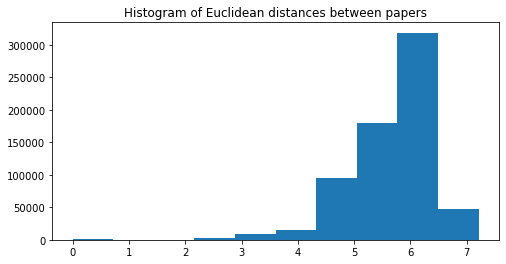

In [7]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [8]:
threshold = mean_distance
A_feature = np.where(distance < threshold, 1,0) # set entry to 1 if smaller than threshold 0 otherwise

#Since distances on the diagonal where 0 we remove the ones one the diagonal 
A_feature = A_feature - np.identity(A_feature.shape[0]) 

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [9]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')

paper_id_to_index = dict()
for index, paper_id in enumerate(np.unique(cora_cites.flatten())):
    paper_id_to_index[paper_id] = index
    
A_citation = np.zeros((len(paper_id_to_index),len(paper_id_to_index)))

for end_paper_id,start_paper_id in cora_cites:
    start_paper_index = paper_id_to_index[start_paper_id]
    end_paper_index = paper_id_to_index[end_paper_id] 
    A_citation[start_paper_index][end_paper_index] = 1

A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [10]:
not_features = pd_content.loc[pd_content['Label'] != my_field] #Get rows in DF where column 'Label' is 'Neural_Networks'
not_features = not_features.drop('Label',axis = 1) #Remove 'Label' column

indexes = np.sort(np.array([paper_id_to_index[paper_id] for paper_id in not_features.index.values]))[::-1]

for paper_index in indexes:
    A_citation = np.delete(A_citation,paper_index,axis = 0)
    A_citation = np.delete(A_citation,paper_index,axis = 1)

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [11]:
for i in range(A_citation.shape[0]):
    for j in range(A_citation.shape[1]):
        if i <= j:
            if A_citation[i][j] == 1:
                A_citation[j][i] = 1
            elif A_citation[j][i] == 1:
                A_citation[i][j] = 1

np.count_nonzero(A_citation - A_citation.transpose())

0

Check the shape of your adjacency matrix again.

In [12]:
A_citation.shape

(818, 818)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [13]:
num_edges_feature = np.sum(A_feature)/2
num_edges_citation = np.sum(A_citation)/2
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 136771.0
Number of edges in the citation graph: 1175.0


Plot the degree distribution histogram for each of the graphs.

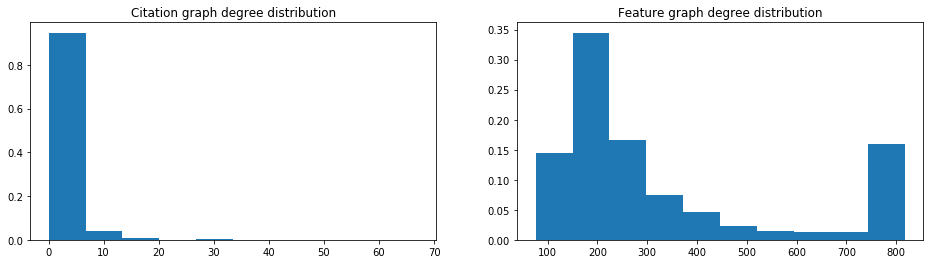

In [14]:
degrees_citation = np.sum(A_citation, axis = 0) #sum on the rows
degrees_feature = np.sum(A_feature, axis = 0)

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization);

Calculate the first and second moments of the degree distribution of each graph.

In [15]:
cit_moment_1 = np.mean(degrees_citation)
cit_moment_2 = np.mean(degrees_citation**2)

feat_moment_1 = np.mean(degrees_feature)
feat_moment_2 = np.mean(degrees_feature**2)

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 2.8728606356968216
2nd moment of citation graph: 23.765281173594133
1st moment of feature graph: 334.4034229828851
2nd moment of feature graph: 167201.19804400977


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**The first moment prive information about the average degree, and the second moment gives use information about the dispresion of the values. 
For citation graph we have small first moment witch is correct since most have small degree every degree are quite similar this is why th 2nd moment is not that high
For fetaure graph the mean is much higher witch is due to higher degrees in the graph and the 2nd moment is high because degree are quite dispere between 100 and 800** 

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

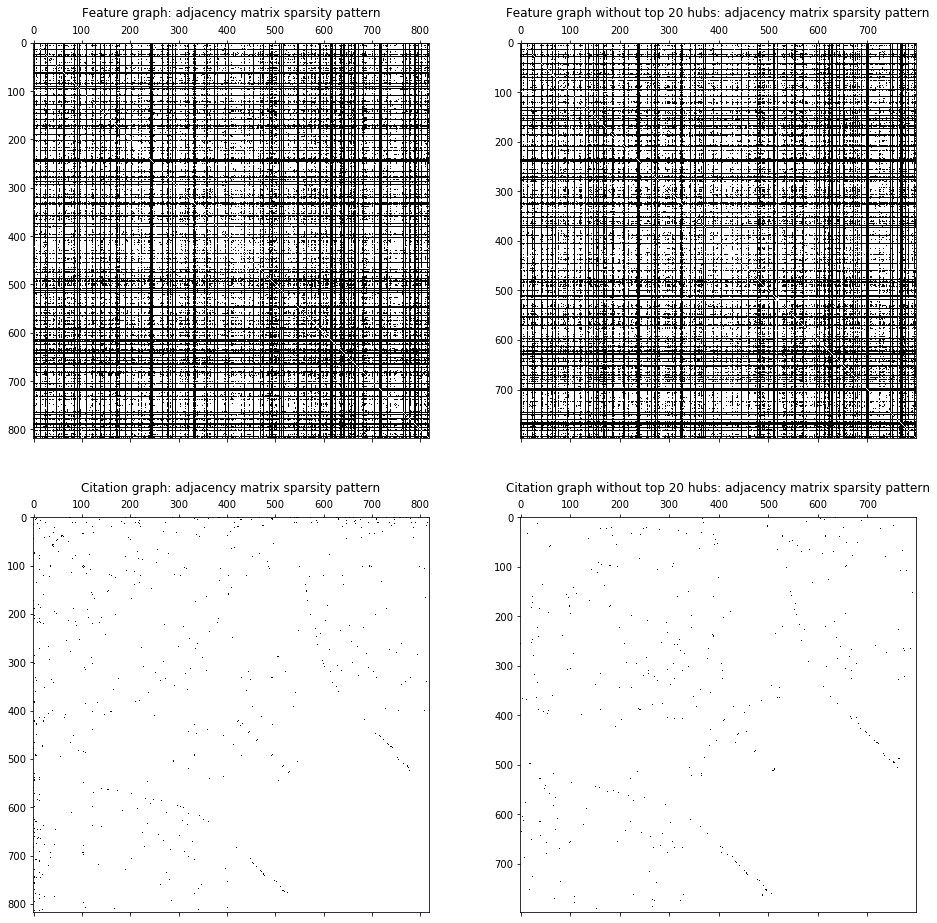

In [16]:
indexes_feature = np.sort(degrees_feature.argsort()[-20:])[::-1] #get index of 20 highest degree
reduced_A_feature = np.delete(A_feature,indexes_feature,axis = 0) 
reduced_A_feature = np.delete(reduced_A_feature,indexes_feature,axis = 1)

indexes_citation = np.sort(degrees_citation.argsort()[-20:])[::-1]
reduced_A_citation = np.delete(A_citation,indexes_citation,axis = 0)
reduced_A_citation = np.delete(reduced_A_citation,indexes_citation,axis = 1)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

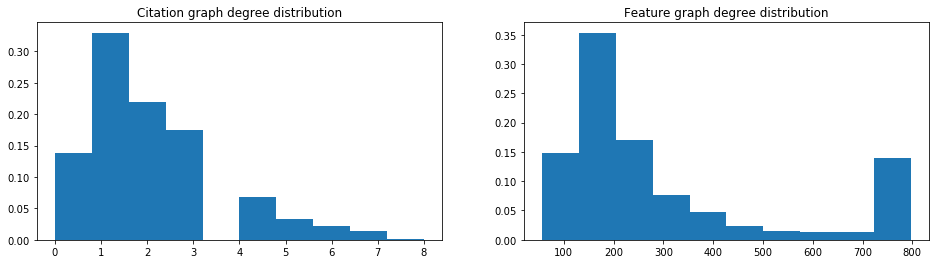

In [17]:
reduced_degrees_feat = np.sum(reduced_A_feature, axis = 0) #sum on the rows
reduced_degrees_cit = np.sum(reduced_A_citation, axis = 0)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [18]:
reduced_cit_moment_1 = np.mean(reduced_degrees_cit)
reduced_cit_moment_2 = np.mean(reduced_degrees_cit**2)

reduced_feat_moment_1 = np.mean(reduced_degrees_feat)
reduced_feat_moment_2 = np.mean(reduced_degrees_feat**2)


print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 1.9724310776942355
Citation graph second moment: 6.2706766917293235
Feature graph first moment:  302.30827067669173
Feature graph second moment:  142170.32581453634


Print the number of edges in the reduced graphs.

In [19]:
num_edges_reduced_feature = np.sum(reduced_A_feature)/2
num_edges_reduced_citation = np.sum(reduced_A_citation)/2

print(f"Number of edges in the reduced feature graph: {num_edges_reduced_feature}")
print(f"Number of edges in the reduced citation graph: {num_edges_reduced_citation}")

Number of edges in the reduced feature graph: 120621.0
Number of edges in the reduced citation graph: 787.0


In [20]:
variation_cit_moment_1 = (1-reduced_cit_moment_1/cit_moment_1)*100
variation_cit_moment_2 = (1-reduced_cit_moment_2/cit_moment_2)*100

varition_feat_moment_1 = (1-reduced_feat_moment_1/feat_moment_1)*100
variation_feat_moment_2 = (1-reduced_feat_moment_2/feat_moment_2)*100

print("Citation graph first moment variation:", variation_cit_moment_1)
print("Citation graph second moment varitation:", variation_cit_moment_2)
print("Feature graph first moment variation: ", varition_feat_moment_1)
print("Feature graph second moment variation: ", variation_feat_moment_2)

Citation graph first moment variation: 31.34261184877086
Citation graph second moment varitation: 73.61412791237353
Feature graph first moment variation:  9.597734383190215
Feature graph second moment variation:  14.97051009340552


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

**With the variation of the moments we clearly see that the effect of removing hub is not the same. The citation graph, due to its fewer number of egdes is much more impacted from the removing of hubs. 
We see that for 1st and 2nd moment the variation for the citation graph and the variation graph are respectivelly :**
- **1st moment : 31.34% and 9.60%** 
- **2nd moment : 73.61% and 14.97%**

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [21]:
threshold = np.percentile(distance,num_edges_citation/num_edges_feature*100)

A_feature_pruned = np.where(distance < threshold, 1,0)
A_feature_pruned = A_feature_pruned - np.identity(A_feature_pruned.shape[0]) 
num_edges_feature_pruned = np.sum(A_feature_pruned)/2

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 136771.0
Number of edges in the feature graph after pruning: 2253.0
Number of edges in the citation graph: 1175.0


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

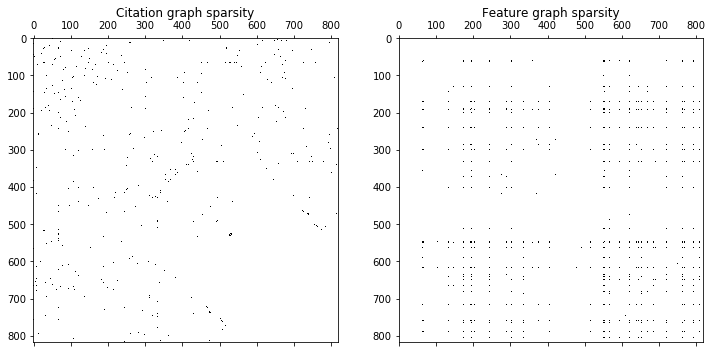

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [23]:
path_matrix_citation = np.zeros(A_citation.shape)
path_matrix_feature = np.zeros(A_feature_pruned.shape)

for i in range(0,11):
    path_matrix_citation += np.linalg.matrix_power(A_citation, i)
    path_matrix_feature += np.linalg.matrix_power(A_feature_pruned, i)

Check the sparsity pattern for both of path matrices.

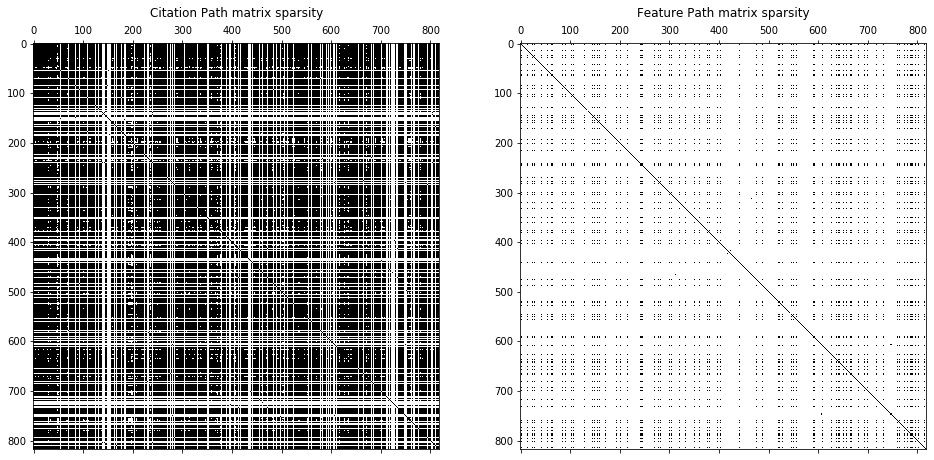

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

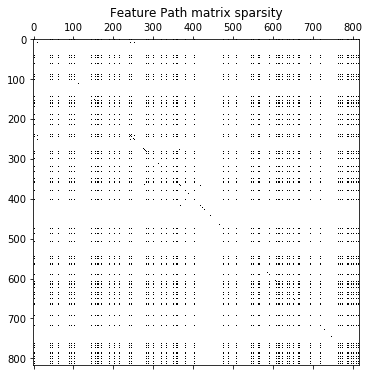

In [25]:
path_matrix_pruned = np.linalg.matrix_power(A_feature_pruned, 10)

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:**

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**To know whether a graph is connected or not we should take a power of the adjacency k with k > number of nodes in the graph. Then if we have a row in this powered matrix where all elements are non zero, then the matrix is connected** 

In [26]:
power_matrix = np.linalg.matrix_power(A_feature,A_feature.shape[0]+1)
print("Rows where a zero elements :",np.where(power_matrix.any(axis=1) == False))

Rows where a zero elements : (array([], dtype=int64),)


**It looks that the feature graph is connected**

If the graph is connected, how can you guess its diameter using the path matrix?

**We compute the paths matrix until all element are non zero, then the diameter is the last power used**

If any of your graphs is connected, calculate the diameter using that process.

In [27]:
path_matrix_feature = np.zeros(A_feature.shape)
i = 0
while (np.count_nonzero(path_matrix_feature) < A_feature.shape[0]):
    path_matrix_feature += np.linalg.matrix_power(A_feature, i)
    i+=1
    
diameter = i
print(f"The diameter is: {diameter}")

The diameter is: 1


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [28]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [29]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [30]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 818, Number of edges: 1175
Number of self-loops: 0, Number of connected components: 104


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [31]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 818, Number of edges: 2253
Number of self-loops: 0, Number of connected components: 669


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [32]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

818

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [33]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

1714.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**We want that p is the number of edges is m divided by the numbe rod edges in a complete graph of size n.<br>
this is**
$p = 2*1714/(n*n-1)$

In [40]:
p = 2*m/((n*n-1))
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [41]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 1715 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**The Barabasi-Albert graph will have m*(n-m) edges<br>
We want to have m that gives the closest value to 1714 $m*(n-m) = 1714$ which gives $m = 2$**

In [101]:
q = int(np.round(np.min(np.roots([1, -n, 1714]))))
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [102]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 1632 edges.


### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [120]:
giant_citation = max(nx.connected_component_subgraphs(G_citation), key=len)
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 636 nodes and 1079 edges.


In [121]:
giant_feature = max(nx.connected_component_subgraphs(G_feature), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 129 nodes and 2228 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [122]:
giant_er = max(nx.connected_component_subgraphs(G_er), key=len)
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 803 nodes and 1715 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**We know $$\frac{N_G}{N} = S = 1 - e^{(k)S}$$
With $$ p = \frac{(k)}{N-1} $$
So we want $$\frac{N_G}{N} = S = 1 - e^{p(N-1)S}$$**

In [142]:
Ng = giant_feature.number_of_nodes()
p_new = np.log(1- Ng/n) /((n-1)*Ng/n)
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [143]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = max(nx.connected_component_subgraphs(G_er_new), key=len)
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

My new Erdos Renyi network that simulates the citation graph has 0 edges.
The giant component of the new Erdos-Rényi network has 1 nodes and 0 edges.


### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

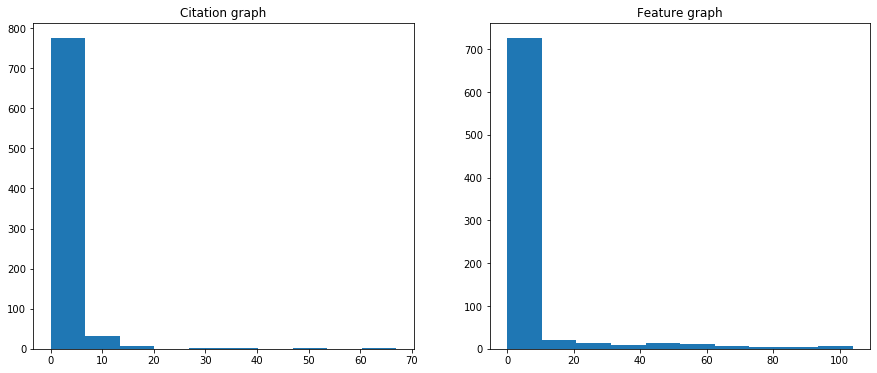

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = [x[1] for x in G_citation.degree()]
axes[0].hist(citation_degrees);
axes[1].set_title('Feature graph')
feature_degrees = [x[1] for x in G_feature.degree()]
axes[1].hist(feature_degrees);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**The degree distribution tells us what proportion of nodes are highly connected and what proportion are less connected, it semms citation graph is a random network whereas Feature graph is a ScaleFree network**

Now, plot the degree distribution historgrams for the simulated networks.

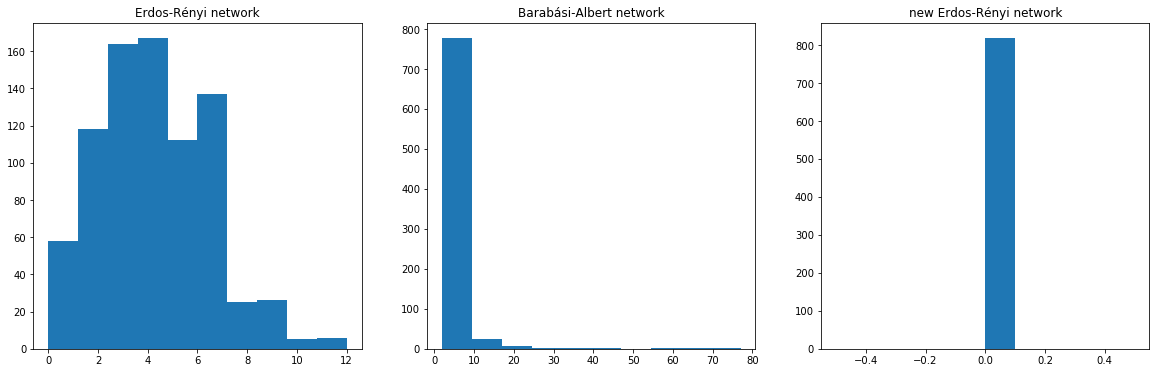

In [160]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = [x[1] for x in G_er.degree()]
axes[0].hist(er_degrees);
axes[1].set_title('Barabási-Albert network')
ba_degrees = [x[1] for x in G_ba.degree()]
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = [x[1] for x in G_er_new.degree()]
axes[2].hist(er_new_degrees);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**There is a match between the citation graph and the BA model but there is no match for the feature graph, to simulate the degree distribution of the citation graph we would prefere to use the Barabasi-Albert network.** 

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [162]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 818 nodes and 2253 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**They are not the same because the way it has been constructed, our fetaure graph don't have self loop whereas configuration model has.** 

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [163]:
nx.average_clustering(G_citation)

0.21693567980632197

In [164]:
nx.average_clustering(G_feature)

0.13686717287541791

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**The cultreting coefficient gives information about the relationship between a node's neighbors. A high clustering coefficient (close to 1) tell's us that the neighbours all know each other, and a small (close to 0) one means they are isolated from each other.
Globally the clustering coefficient for the citation and feature graph are low, that means that the graph are not well connected and that we should have several components**

Now, let us check the average clustering coefficient for the simulated networks.

In [165]:
nx.average_clustering(G_er)

0.0027708979420470866

In [166]:
nx.average_clustering(G_ba)

0.030477305199341914

In [167]:
nx.average_clustering(nx.Graph(G_config))

0.06878812730599851

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Way smaller than before, no good fit they are all to small**

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**For feature the powerlaw_cluster_graph will be nice**

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [173]:
G_best = nx.powerlaw_cluster_graph(818, int(2253/818), 0.13686717287541791, seed=None)
print('Number of nodes: {}, Number of edges: {}'. format(G_best.number_of_nodes(), G_best.number_of_edges()))

Number of nodes: 818, Number of edges: 1632


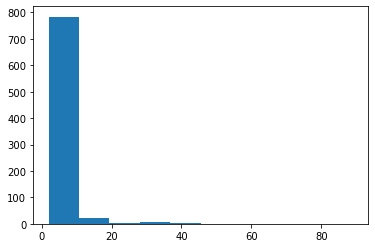

In [172]:
best_degrees = [x[1] for x in G_best.degree()]
plt.hist(best_degrees);

Comment on the similarities of your match.

**Not that bad**